# 5. Curve Interpolation

In [3]:
from fixedincome2025 import table

## What To Do With Missing Points? 

* When you compute the present value (PV) of your bond portfolio in practice, there will be missing points on the yield curve
* Treasury yield curve from [treasury.gov](https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025): 

In [19]:
table('yc_09152025')

Date,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
09/15/2025,4.22%,4.21%,4.17%,4.06%,4.00%,3.81%,3.64%,3.54%,3.50%


* Imagine you have a Treasury bond that's 11M from its maturity, and the second-to-last coupon payment is 5M from now
* You need 5M point and 11M point to price the bond
* One also needs to take DCC into consideration when computing the year fractions ($T$ in the discount factor $e^{-TR(0, T)}$)

## A World of Curves

* Although we've been using the Treasury yield curve as our only example, in practice there are many other curves
    * Important ones are SOFR, Term SOFR, fed funds, LIBOR
    * SOFR is by far the most important one if you work in the rates business in a bank, more important than the Treasury yield curve
    * In the rates business, many curves are simply a spread curve plus the SOFR curve, spread from basis swap quotes
    * In a credit desk (trading credit projects including corporate bonds), corporate bond yield curves are a spread curve (known as the z-spread) plus the Treasury yield curve
* **Each curve has its own 6 representations**
* Below is how a SOFR curve should be interpolated

## Curve Interpolation Methods

* Curve interpolation is on the time-weighted zero rate $TR(0, T)$
* The interpolation method is
    * Linear interpolation in the short end
    * Cubic spline for the rest
* Cutoff is around 3Y, a decision more of an art than science

## Why Linear Interpolation on Time-Weighted Zero Rate? 

* Recall that
\begin{align*}
f(0, T) &= \frac{\partial }{\partial T} [TR(0, T)]
\end{align*}
* The reason people use linear interpolation on time-weighted zero rate in the short end is that we want its first derivative, the instantaneous forward curve ($f(0, T)$ for all $T$), to be a step function in the short end
* Linear interpolating function: Piecewise linear
* Step function: Piecewise constant
* The first derivative of a linear interpolating function is a step function

## Why Piecewise Constant $f(0, T)$? 

* Recall that
$$
L(0, T, T+\tau) = \frac{1}{\tau}\left(e^{\int_T^{T+\tau} f(0, u)\,du} - 1\right)
$$
* A variant of this formula is used to quote FRAs (and swaps)
* Recall the CME Term SOFR example

In [12]:
table('term_sofr')

,Term SOFR 1M,Term SOFR 3M,Term SOFR 6M,Term SOFR 12M
09-17-2025,4.13359 %,4.02304 %,3.85385 %,3.59516 %
09-16-2025,4.13584 %,4.02570 %,3.85447 %,3.60384 %
09-15-2025,4.14288 %,4.02330 %,3.84833 %,3.60702 %


## Why Piecewise Constant $f(0, T)$? (Cont.)

* Think of
$$
f(0, T) = L(0, T, T+\epsilon)
$$ 
for $\epsilon=$1d
* Market quote of $f(0, T)$, like $L(0, T, T+\tau)$, is implied by the prices of market instruments and cannot be chosen subjectively
    * It is not a matter of opinion
    * Posting an incorrect quote creates an arbitrage opportunity

* $f(0, T)$ is the market anticipated time-$T$ (in the future) daily SOFR fixings, which should stay constant between fed rate decisions

* The discontinuities are [FOMC meeting dates](https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm)

## Linear Interpolation on Time-Weighted Zero Rate

* In conclusion, it makes sense for the $TR(0, T)$ curve to be a linear function between FOMC meetings dates in the short end
* The slope of $TR(0, T)$ at $T=T^*$ equals $f(0, T^*)$, which is the anticipated SOFR daily fixing level at $T^*$
* FOMC meeting schedule is not determined for 3Y out, why not just make the curve continuous and smooth? 

## Short End Curve Interpolation: Example I

* Assuming: 
    * Today's SOFR yield curve is as below
    * From the 2M point to the 3M point there will be no FOMC meetings
    * 30/360 DCC
* What should the yield be at the 2.5M point?

In [27]:
table('yc_sofr_example')

1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
4.22%,4.21%,4.17%,4.06%,4.00%,3.81%,3.64%,3.54%,3.50%


* Between 2M and 3M, $TR(0, T)$ must be a linear function, so we have 
\begin{align*}
&\left(\frac{2}{12}\times 4.17\% + \frac{3}{12}\times 4.06\%\right)/2 = \frac{2.5}{12} \times R\\
\end{align*}
and hence $R = 4.104\%$

## Short End Curve Interpolation: Exercise I

* Assuming: 
    * Today's SOFR yield curve is as below
    * Between the 2M point and the 3M point there will be no FOMC meetings
    * 30/360 DCC
* What should the yield be at the 2.333M point?

In [28]:
table('yc_sofr_exercise')

1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
4.20%,4.19%,4.15%,4.04%,4.00%,3.81%,3.62%,3.51%,3.47%


## Short End Curve Interpolation: Example II

* Assuming: 
    * Today's SOFR yield curve is as below
    * Between the 1.5M point and the 2M point there will be no FOMC meetings
    * Between the 3M point and the 3.5M point there will be no FOMC meetings
    * There is an FOMC meeting at the 2.5M point where the consensus is that the Fed will $100\%$ cut its rate by 25 bps
    * SOFR daily rates moves at the same time by the same amount as the fed funds rate
    * 30/360 DCC
* What should the yield be at the 3.333M point?

In [27]:
table('yc_sofr_example')

1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
4.22%,4.21%,4.17%,4.06%,4.00%,3.81%,3.64%,3.54%,3.50%


## Short End Curve Interpolation: Example II (Cont.)

In [27]:
table('yc_sofr_example')

1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
4.22%,4.21%,4.17%,4.06%,4.00%,3.81%,3.64%,3.54%,3.50%


* Recall that the slope of $TR(0, T)$ in the interval [1.5M, 2M] is $f(0, T)$, the anticipated SOFR daily fixing level in that interval. Numerically, it's
\begin{align*}
\frac{2\times 4.17\% - 1.5\times 4.21\%}{0.5} = 4.05\%
\end{align*}

* Similarly, the slope of $TR(0, T)$ in the interval [3M, 3.5M] is the anticipated SOFR daily fixings in that interval, which is $4.05\% - 0.25\% = 3.8\%$

* The slope can also be written in terms of yield at the 3M point and the 3.3333M point as
\begin{align*}
\frac{3.3333\times R - 3\times 4.06}{0.3333}, 
\end{align*}
which we know should be $3.8\%$. Thus $R$ can be backed out to be $4.034\%$

## Short End Curve Interpolation: Exercise II

* Assuming: 
    * Today's SOFR yield curve is as below
    * Between the 1.5M point and the 2M point there will be no FOMC meetings
    * Between the 3M point and the 4M point there will be no FOMC meetings
    * There is an FOMC meeting at the 2.5M point where the consensus is that the Fed will $100\%$ cut its rate by 25 bps
    * SOFR daily rates moves at the same time by the same amount as the fed funds rate
    * 30/360 DCC
* What should the yield be at the 3.5M point?

In [32]:
table('yc_sofr_exercise')

1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr
4.20%,4.19%,4.15%,4.04%,4.00%,3.81%,3.62%,3.51%,3.47%


## Jump Size Always (Multiple of) 25 Bps? 

* No
* Above computation only works if the market is in good agreement on what will happen in the next FOMC meeting
* Only in such situation you know the jump size of the step function
* When market is not in good agreement, the jump size is an average of participants' view

In [33]:
table('forward_rate_jump_size')

Meeting Date,10/29/2025,12/10/2025,1/28/2026,3/18/2026,4/29/2026
Jump Size (bps),-22.5,-17.9,-12.1,-9.5,-6.2


## Is the Market Often in Good Agreement?

* Sometimes
* [Federal Funds Target Rate Chart](https://fred.stlouisfed.org/series/DFEDTARU)
* When the market is in good agreement, it's usually only for the next meeting
* The meetings after that will be too far
* Fed rate decision is driven by unpredictable economic data
    * inflation, labor market, GDP growth, etc.
* [The CME FedWatch Tool](https://www.cmegroup.com/markets/interest-rates/cme-fedwatch-tool.html)

## Unpredictability of the Economic Data

* Weather data is significantly easier to predict than economic data
    * Weather data: Complex but understood physical processes
    * Economic data: Unpredictable and irrational human behavior
* Economic data is becoming more unpredictable due to 
    * Increasing complexity of economic systems
    * Decline in the quality and reliability of U.S. economic data caused by budget cuts and falling survey response rates
    * Unexpected global events like pandemics and geopolitical conflicts
    * Lack of clarity surrounding government policies
* Economic uncertainty can harm business investment and hiring, as businesses struggle to plan in a constantly shifting environment

## What About Long End of the Curve?

* For yield curve that's 3Y away, the same state data $TR(0, T)$ is used in interpolation
* We want forward rate to be continuous and smooth
    * Smooth means 1st order derivative is continuous
\begin{align*}
f(0, T) &= \frac{\partial }{\partial T} [TR(0, T)]
\end{align*}
* We need the $TR(0, T)$ curve to be continuous and have continuous 1st and 2nd derivatives

## Differentiation and Smoothness

* Integrating a piecewise function removes value discontinuities
* Jumps in the integrand (blue) turn into kinks in the integral (orange)

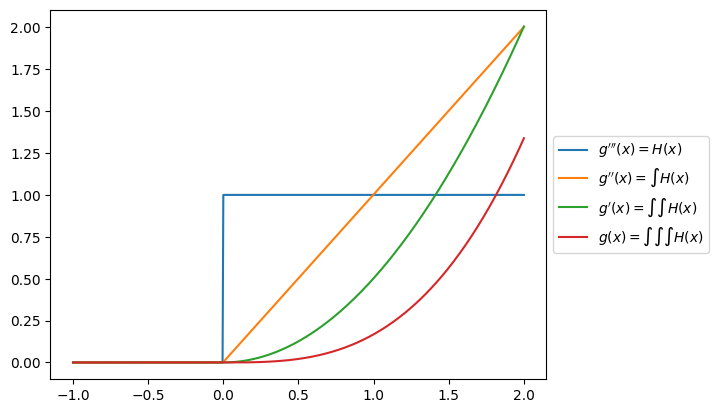

In [47]:
from gfuncpy import gfunc, Identity

@gfunc
def H(x):
    if x < 0:
        return 0
    else:
        return 1

x = Identity([-1, 2])

gppp = H(x)
gpp  = H(x).int()
gp   = H(x).int().int()
g    = H(x).int().int().int()

gppp.plot(label=r"$g'''(x) = H(x)$")
gpp.plot(label=r"$g''(x) = \int H(x)$")
gp.plot(label=r"$g'(x) = \int\int H(x)$")
g.plot(label=r"$g(x) = \int\int\int H(x)$")

## [GFuncPy](https://gfuncpy.readthedocs.io/en/latest/)

## Piecewise Cubic Functions

* The more times you integrate a piecewise function, the more smooth it becomes
* We want $f(0, T)$ to at least look like the green curve, no kinks, so $TR(0, T)$ will look like the red curve, a piecewise cubic function

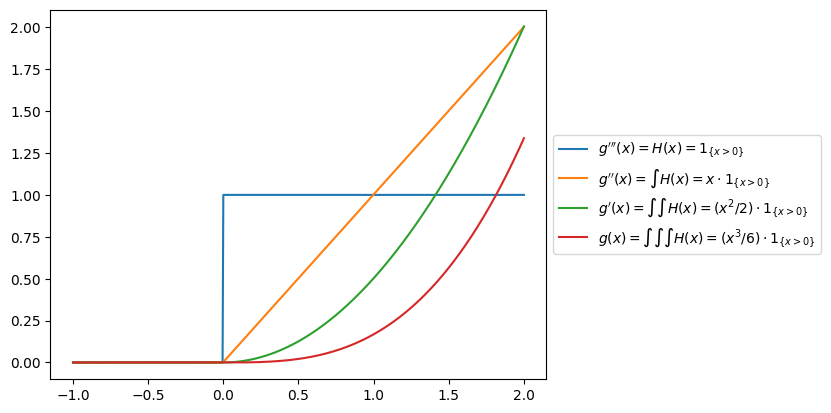

In [50]:
from gfuncpy import gfunc, Identity

@gfunc
def H(x):
    if x < 0:
        return 0
    else:
        return 1

x = Identity([-1, 2])

gppp = H(x)
gpp  = H(x).int()
gp   = H(x).int().int()
g    = H(x).int().int().int()

gppp.plot(label=r"$g'''(x) = H(x) = 1_{\{x>0\}}$")
gpp.plot(label=r"$g''(x) = \int H(x) = x\cdot 1_{\{x>0\}}$")
gp.plot(label=r"$g'(x) = \int\int H(x) = (x^2/2)\cdot 1_{\{x>0\}}$")
g.plot(label=r"$g(x) = \int\int\int H(x) = (x^3/6)\cdot 1_{\{x>0\}}$")

## Interpolating Cubic Spline

* An interpolating cubic spline $s(x)$ is a piecewise function
* The curve is a cubic function $a_j x^3 + b_j x^2 + c_j x + d_j$ in each subinterval
* Coefficients $\{a_j\}, \{b_j\}, \{c_j\}, \{d_j\}$ are chosen to make $s(x), s'(x), s''(x)$ continuous
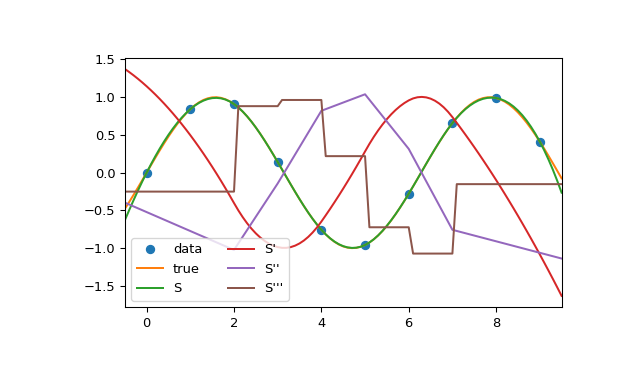
* Plot from [SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html)

## Cubic Spline (Classic) Construction

* One way to construct $s(x)$ is to list equations for all coefficients and solve the system
* If we have $n$ subintervals, there will be $4n$ coefficients

* Each cubic polynomial has to go through the two end points in the corresponding subinterval, giving $2n$ equations

* Continuity of $s'(x)$ at the *knots* ($\{x_j\}_{j=0}^n$) gives $n-1$ equations

* Continuity of $s''(x)$ at the *knots* gives $n-1$ equations

* We are left with $4n - 2n - (n-1) - (n-1) = 2$ degrees of freedom for boundary contitions
    * Natural boundary condition: $s''(x_0) = s''(x_n) = 0$

## Cubic B-Spline Construction

* A better way, known as the basis-spline, or the B-spline, is to construct $s(x)$ as a linear combination of basis functions
$$
s(x) = \sum_{j=0}^n c_j B_{j,3}(x)
$$
* Basis functions can be precomputed and stored, speeding up the construction of $s(x)$
* Easy to add/remove knots, it will be just reconstructing a few basis functions in the neighborhood that needs change
* De Boor's Algorithm
$$
B_{i,0}(x) =
\begin{cases}
1 & \text{if } \quad x_i \leq x < x_{i+1} \\
0 & \text{otherwise}
\end{cases}
$$
$$
B_{i,p}(x) = \frac{x - x_i}{x_{i+p} - x_i} B_{i,p-1}(x) + \frac{x_{i+p+1} - x}{x_{i+p+1} - x_{i+1}} B_{i+1,p-1}(x)
$$

## De Boor's Algorithm: Piecewise Constant

* Assuming $x_j = j$, a uniform grid with grid spacing 
$$
B_{i,0}(x) =
\begin{cases}
1 & \text{if } \quad x_i \leq x < x_{i+1} \\
0 & \text{otherwise}
\end{cases}
$$

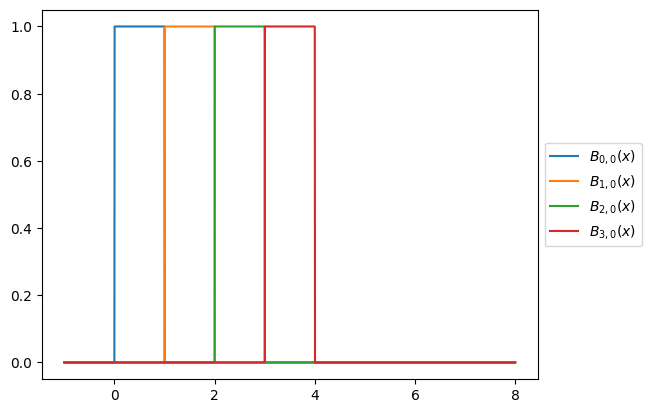

In [98]:
from functools import partial
from gfuncpy import gfunc

def B(x, idx):
    if idx < x <= idx + 1:
        return 1
    else: 
        return 0

B_00 = gfunc(partial(B, idx=0))
B_10 = gfunc(partial(B, idx=1))
B_20 = gfunc(partial(B, idx=2))
B_30 = gfunc(partial(B, idx=3))
B_40 = gfunc(partial(B, idx=4))
B_50 = gfunc(partial(B, idx=5))
B_60 = gfunc(partial(B, idx=6))

x = Identity([-1, 8])

B_00(x).plot(label=r'$B_{0, 0}(x)$')
B_10(x).plot(label=r'$B_{1, 0}(x)$')
B_20(x).plot(label=r'$B_{2, 0}(x)$')
B_30(x).plot(label=r'$B_{3, 0}(x)$')

## De Boor's Algorithm: Piecewise Linear

$$
B_{i,p}(x) = \frac{x - x_i}{x_{i+p} - x_i} B_{i,p-1}(x) + \frac{x_{i+p+1} - x}{x_{i+p+1} - x_{i+1}} B_{i+1,p-1}(x)
$$
* Plug in $x_j = j, p=1$: 
\begin{align*}
B_{0,1}(x) &= (x-0) B_{0,0}(x) + (2-x) B_{1,0}(x)\qquad i=0, \\
B_{1,1}(x) &= (x-1) B_{1,0}(x) + (3-x) B_{2,0}(x)\qquad i=1, \\
B_{2,1}(x) &= (x-2) B_{2,0}(x) + (4-x) B_{3,0}(x)\qquad i=2, \\
B_{3,1}(x) &= (x-3) B_{3,0}(x) + (5-x) B_{4,0}(x)\qquad i=3\\
\end{align*}

## De Boor's Algorithm: Piecewise Linear

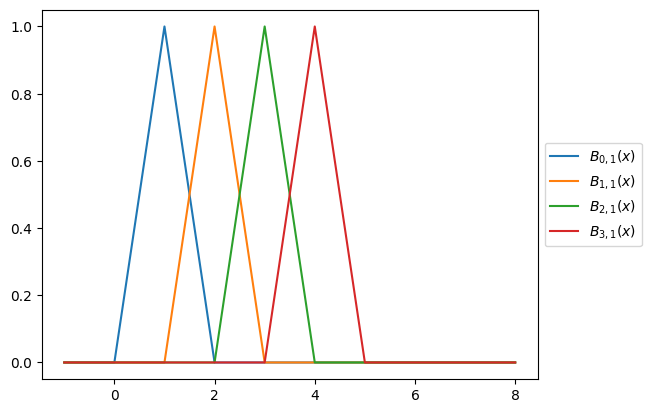

In [99]:
B_01 = (x-0)*B_00(x) + (2-x)*B_10(x)
B_11 = (x-1)*B_10(x) + (3-x)*B_20(x)
B_21 = (x-2)*B_20(x) + (4-x)*B_30(x)
B_31 = (x-3)*B_30(x) + (5-x)*B_40(x)
B_41 = (x-4)*B_40(x) + (6-x)*B_50(x)
B_51 = (x-5)*B_50(x) + (7-x)*B_60(x)

B_01.plot(label=r'$B_{0, 1}(x)$')
B_11.plot(label=r'$B_{1, 1}(x)$')
B_21.plot(label=r'$B_{2, 1}(x)$')
B_31.plot(label=r'$B_{3, 1}(x)$')

## De Boor's Algorithm: Piecewise Quadratic

$$
B_{i,p}(x) = \frac{x - x_i}{x_{i+p} - x_i} B_{i,p-1}(x) + \frac{x_{i+p+1} - x}{x_{i+p+1} - x_{i+1}} B_{i+1,p-1}(x)
$$
* Plug in $x_j = j, p=2$: 
\begin{align*}
B_{0,2}(x) &= \left(\frac{x-0}{2}\right) B_{0,1}(x) + \left(\frac{3-x}{2}\right) B_{1,1}(x)\qquad i=0, \\
B_{1,2}(x) &= \left(\frac{x-1}{2}\right) B_{1,1}(x) + \left(\frac{4-x}{2}\right) B_{2,1}(x)\qquad i=1, \\
B_{2,2}(x) &= \left(\frac{x-2}{2}\right) B_{2,1}(x) + \left(\frac{5-x}{2}\right) B_{3,1}(x)\qquad i=2, \\
B_{3,2}(x) &= \left(\frac{x-3}{2}\right) B_{3,1}(x) + \left(\frac{6-x}{2}\right) B_{4,1}(x)\qquad i=3\\
\end{align*}

## De Boor's Algorithm: Piecewise Quadratic

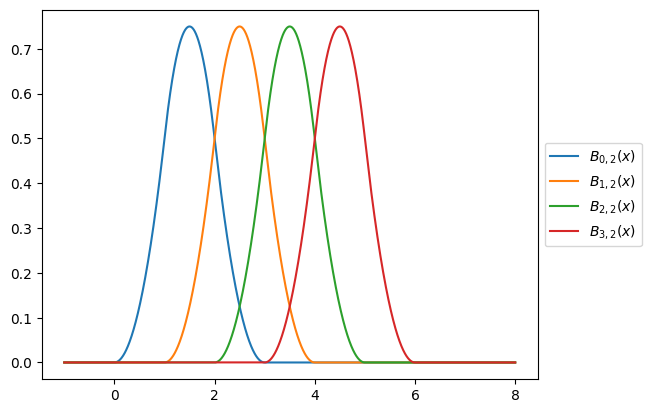

In [100]:
B_02 = ((x-0)*B_01 + (3-x)*B_11)/2
B_12 = ((x-1)*B_11 + (4-x)*B_21)/2
B_22 = ((x-2)*B_21 + (5-x)*B_31)/2
B_32 = ((x-3)*B_31 + (6-x)*B_41)/2
B_42 = ((x-4)*B_41 + (7-x)*B_51)/2

B_02.plot(label=r'$B_{0, 2}(x)$')
B_12.plot(label=r'$B_{1, 2}(x)$')
B_22.plot(label=r'$B_{2, 2}(x)$')
B_32.plot(label=r'$B_{3, 2}(x)$')

## De Boor's Algorithm: Piecewise Cubic

$$
B_{i,p}(x) = \frac{x - x_i}{x_{i+p} - x_i} B_{i,p-1}(x) + \frac{x_{i+p+1} - x}{x_{i+p+1} - x_{i+1}} B_{i+1,p-1}(x)
$$
* Plug in $x_j = j, p=3$: 
\begin{align*}
B_{0,3}(x) &= \left(\frac{x-0}{3}\right) B_{0,2}(x) + \left(\frac{4-x}{3}\right) B_{1,2}(x)\qquad i=0, \\
B_{1,3}(x) &= \left(\frac{x-1}{3}\right) B_{1,2}(x) + \left(\frac{5-x}{3}\right) B_{2,2}(x)\qquad i=1, \\
B_{2,3}(x) &= \left(\frac{x-2}{3}\right) B_{2,2}(x) + \left(\frac{6-x}{3}\right) B_{3,2}(x)\qquad i=2, \\
B_{3,3}(x) &= \left(\frac{x-3}{3}\right) B_{3,2}(x) + \left(\frac{7-x}{3}\right) B_{4,2}(x)\qquad i=3\\
\end{align*}

## De Boor's Algorithm: Piecewise Cubic

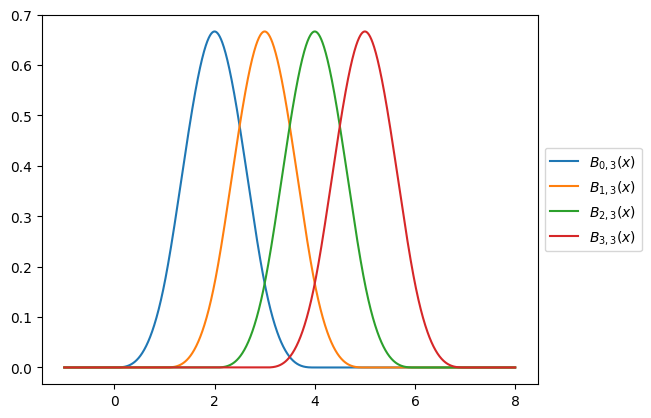

In [101]:
B_03 = ((x-0)*B_02 + (4-x)*B_12)/3
B_13 = ((x-1)*B_12 + (5-x)*B_22)/3
B_23 = ((x-2)*B_22 + (6-x)*B_32)/3
B_33 = ((x-3)*B_32 + (7-x)*B_42)/3

B_03.plot(label=r'$B_{0, 3}(x)$')
B_13.plot(label=r'$B_{1, 3}(x)$')
B_23.plot(label=r'$B_{2, 3}(x)$')
B_33.plot(label=r'$B_{3, 3}(x)$')

## De Boor's Algorithm: Non-Uniform Grid

$$
B_{i,0}(x) =
\begin{cases}
1 & \text{if } \quad x_i \leq x < x_{i+1} \\
0 & \text{otherwise}
\end{cases}
$$
$$
B_{i,p}(x) = \frac{x - x_i}{x_{i+p} - x_i} B_{i,p-1}(x) + \frac{x_{i+p+1} - x}{x_{i+p+1} - x_{i+1}} B_{i+1,p-1}(x)
$$

* The algorithm does not say anything about what the grid should be
* In particular, it does not have to be uniform
* In the market, the liquid points on the curve (where we have reliable real time data) do not form a uniform grid

In [104]:
table('yc_long_end')

Date,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
9/29/2025,3.63,3.63,3.74,3.92,4.15,4.69,4.71


## [scipy.interpolate.CubicSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html) Example

```python
import numpy as np
from scipy.interpolate import CubicSpline
from gfuncpy import Identity, gfunc
import matplotlib.pyplot as plt

T_knots = np.array([3, 5, 7, 10, 20, 30])
R = np.array([3.63, 3.74, 3.92, 4.15, 4.69, 4.71])

cs = CubicSpline(T_knots, T_knots*R)  # time weighted zero rate

@gfunc
def TR(x):
    return cs(x)

T = Identity([3, 30])

(TR(T)/T).plot()
plt.plot(T_knots, R, 'o')
plt.show()
```

## [scipy.interpolate.CubicSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html) Example (Cont.)

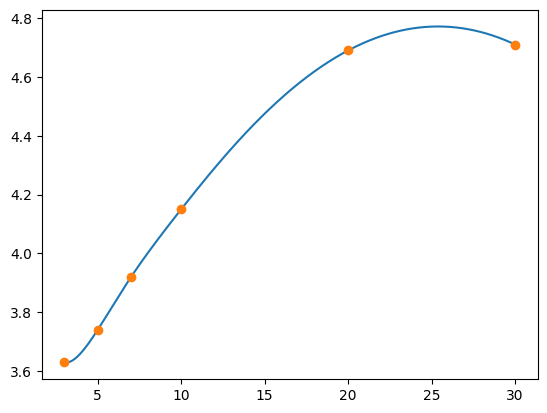

In [118]:
import numpy as np
from scipy.interpolate import CubicSpline
from gfuncpy import Identity, gfunc
import matplotlib.pyplot as plt

T_knots = np.array([3, 5, 7, 10, 20, 30])
R = np.array([3.63, 3.74, 3.92, 4.15, 4.69, 4.71])

cs = CubicSpline(T_knots, T_knots*R)  # time weighted zero rate

@gfunc
def TR(x):
    return cs(x)

T = Identity([3, 30])

(TR(T)/T).plot()
plt.plot(T_knots, R, 'o')
plt.show()